# Number of indexed/deindexed/active journals in the SciELO network

This analysis shows the
annual evolution of the number of indexed, deindexed and active journals
of each collection,
and of the whole network.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
%matplotlib inline

## Loading the dataset

We're going to use the network `journals.csv` for that.

In [3]:
journals = pd.read_csv("tabs_network/journals.csv")

The following ISSN cleaning/normalization step
is fully documented in a normalization-specific notebook
that can be found together with this one
in the same repository.

In [4]:
issn_scielo_fix = {"0001-6002": "0001-6012",
                   "0258-6444": "2215-3535",
                   "0325-8203": "1668-7027",
                   "0719-448x": "0719-448X",
                   "0797-9789": "1688-499X",
                   "0807-8967": "0870-8967",
                   "0858-6444": "0258-6444",
                   "1315-5216": "1316-5216",
                   "1667-8682": "1667-8982",
                   "1678-5177": "0103-6564",
                   "1683-0789": "1683-0768",
                   "1688-4094": "1688-4221",
                   "1852-4418": "1852-4184",
                   "1980-5438": "0103-5665",
                   "2175-3598": "0104-1282",
                   "2233-7666": "2223-7666",
                   "2237-101X": "1518-3319",
                   "2993-6797": "2393-6797"}
journals["ISSN SciELO"].replace(issn_scielo_fix, inplace=True)

We don't need all the columns from the `journals.csv`.

In [5]:
journals.columns

Index(['extraction date', 'study unit', 'collection', 'ISSN SciELO', 'ISSN's',
       'title at SciELO', 'title thematic areas',
       'title is agricultural sciences', 'title is applied social sciences',
       'title is biological sciences', 'title is engineering',
       'title is exact and earth sciences', 'title is health sciences',
       'title is human sciences', 'title is linguistics, letters and arts',
       'title is multidisciplinary', 'title current status',
       'title + subtitle SciELO', 'short title SciELO', 'short title ISO',
       'title PubMed', 'publisher name', 'use license', 'alpha frequency',
       'numeric frequency (in months)', 'inclusion year at SciELO',
       'stopping year at SciELO', 'stopping reason',
       'date of the first document', 'volume of the first document',
       'issue of the first document', 'date of the last document',
       'volume of the last document', 'issue of the last document',
       'total of issues', 'issues at 2018', 'is

These are the columns we need:

In [6]:
columns = ["collection", "ISSN SciELO",
           "inclusion year at SciELO", "stopping year at SciELO"]
journals[columns].head()

,collection,ISSN SciELO,inclusion year at SciELO,stopping year at SciELO
0,scl,1676-5648,2006,2010.0
1,scl,0101-8108,2004,2012.0
2,scl,0034-7701,2000,2008.0
3,scl,0102-261X,1999,2012.0
4,scl,1516-9332,2005,2009.0


In [7]:
journals[columns].shape

(1721, 4)

## Data de-duplication & `inf` instead of `NaN`

Each ISSN may appear in more than one collection
and perhaps more than once in a collection,
as the `ISSN SciELO` column is normalized, not the rows.
As an example of that:

In [8]:
journals[columns][journals["ISSN SciELO"].isin(["0103-5665", "0104-1282"])]

,collection,ISSN SciELO,inclusion year at SciELO,stopping year at SciELO
63,scl,0103-5665,2006,2015.0
1436,psi,0103-5665,2015,2015.0
1449,psi,0104-1282,2012,NaN
1455,psi,0104-1282,2008,NaN
1459,psi,0103-5665,2008,NaN


These rows are inconsistent,
as the inclusion year is different for the same ISSN.
At least, these are the only inconsistent entries in the dataset:

In [9]:
is_consistent = (
    journals[columns]
        .groupby(["collection", "ISSN SciELO"])
        .apply(lambda df: df.apply(set).apply(len).sum() == df.size)
        .rename("is_consistent")
)
pd.DataFrame(is_consistent[~is_consistent])

is_consistent
collection ISSN SciELO               
psi        0103-5665            False
           0104-1282            False

Then let's get the consistent dataset
while keeping the index in "sync" with the full journals dataframe.
We'll replace the `NaN` by `inf` (infinity) in the stopping year column
in order to make it the greates possible value
(which will also be required later on).

In [10]:
dataset = (journals
    .reset_index()
    .fillna({"stopping year at SciELO": np.inf})
    .groupby(["collection", "ISSN SciELO"])
    .aggregate({
        "inclusion year at SciELO": "min",
        "stopping year at SciELO": "max",
        "index": "max",
    })
    .reset_index()
    .set_index("index")
)
dataset.iloc[::312]

,collection,ISSN SciELO,inclusion year at SciELO,stopping year at SciELO
index,,,,
376,arg,0002-7014,2003,2014.000000
760,col,0120-3886,2013,inf
1000,esp,0213-6163,2005,2017.000000
1327,prt,0874-4890,2010,2012.000000
115,scl,0102-8529,2007,inf
1549,sss,1819-0545,2006,inf


The previous cell has a quite generic code that should work on any input.
But in our case, it could be simpler,
since only two rows had been removed (as expected):

In [11]:
dataset.shape

(1719, 4)

The duplicated entries were fixed:

In [12]:
dataset[dataset["ISSN SciELO"].isin(["0103-5665", "0104-1282"])]

,collection,ISSN SciELO,inclusion year at SciELO,stopping year at SciELO
index,,,,
1459,psi,0103-5665,2008,inf
1455,psi,0104-1282,2008,inf
63,scl,0103-5665,2006,2015.000000


A simpler (but not recommended) approach
would be the removal of the two duplicated rows:
$1436$, $1449$.

In [13]:
journals.drop([1436, 1449]).shape

(1719, 98)

Is it really the same?

In [14]:
journals.drop([1436, 1449])[columns].fillna(np.inf).eq(dataset).all()

collection                  True
ISSN SciELO                 True
inclusion year at SciELO    True
stopping year at SciELO     True
dtype: bool

## Number of active journals in the network

How many active journals does the network have?

In [15]:
dataset[dataset["stopping year at SciELO"] == np.inf]["ISSN SciELO"].drop_duplicates().count()

1345

Actually, that number isn't *clean*,
since a journal can't be said *active*
just because it's was never deindexed
in a now discontinued collection.

### Social Sciences (`sss`) collection normalization

There are $10$ journals from the `sss` collection
that could be regarded as deindexed
from the year when `sss` was discontinued.

In [16]:
dataset[(dataset["stopping year at SciELO"] == np.inf) &
        (dataset["collection"] != "sss")]["ISSN SciELO"].drop_duplicates().count()

1335

That's another kind of normalization step:
enforcing that the `sss` collection had all its entries
deindexed in $2010$.

In [17]:
sss_discontinuation_year = 2010
sss_selector = dataset[dataset["collection"] == "sss"].index
# The "max" step is just for consistency
# regarding an extraordinary entry included in 2017
dataset.loc[sss_selector, "stopping year at SciELO"] = \
    dataset[dataset["collection"] == "sss"].T.apply(
        lambda row: max(min(sss_discontinuation_year,
                            row["stopping year at SciELO"]),
                        row["inclusion year at SciELO"])
    )

### Yearly totals

How many had been active in the past years?
In order to answer this one,
we'll need to count how many journals had been indexed and deindexed on each year,
grouping them to de-duplicate when any of them appears in more than one collection.

In [18]:
network_years = dataset.groupby(["ISSN SciELO"]).aggregate({
    "inclusion year at SciELO": "min",
    "stopping year at SciELO": "max",
})
network_years.head()

,inclusion year at SciELO,stopping year at SciELO
ISSN SciELO,,
0001-3714,1999,2000.000000
0001-3765,2000,inf
0001-6012,2002,inf
0001-6365,2001,2012.000000
0002-0591,2013,2015.000000


In [19]:
network_index = pd.DataFrame({
    "indexed": network_years.groupby("inclusion year at SciELO").size(),
    "deindexed": network_years.groupby("stopping year at SciELO").size(),
}).fillna(0) \
  .assign(total=lambda df: (df["indexed"] - df["deindexed"]).cumsum()) \
  .drop(np.inf)
network_index

,indexed,deindexed,total
1997.0,9.0,1.0,8.0
1998.0,29.0,0.0,37.0
1999.0,15.0,1.0,51.0
2000.0,28.0,3.0,76.0
2001.0,26.0,2.0,100.0
2002.0,67.0,5.0,162.0
2003.0,43.0,3.0,202.0
2004.0,57.0,5.0,254.0
2005.0,83.0,10.0,327.0
2006.0,132.0,6.0,453.0


The totals are the difference of the cumulative sum
of the indexed/deindexed columns.
Numbers might be difficult to understand,
let's plot this data.

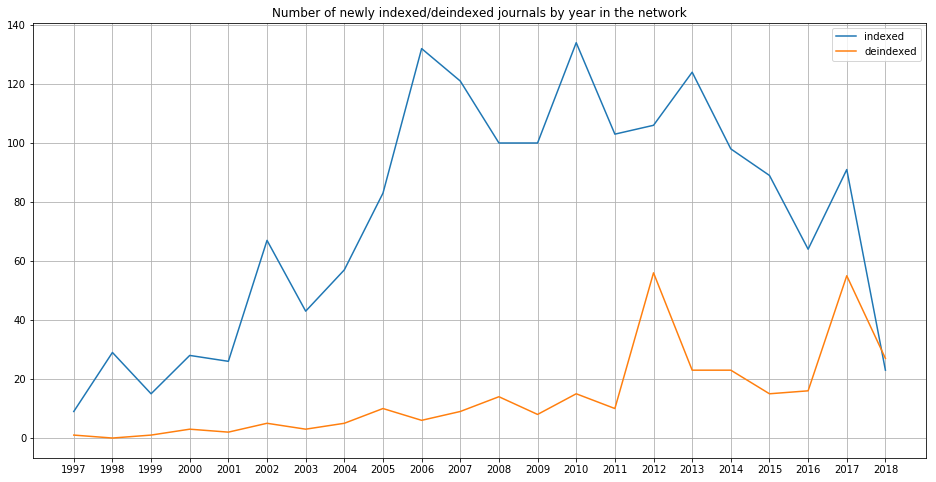

In [20]:
network_index[["indexed", "deindexed"]].plot(
    figsize=(16, 8),
    title="Number of newly indexed/deindexed journals by year in the network",
    xticks=network_index.index,
    grid=True,
);

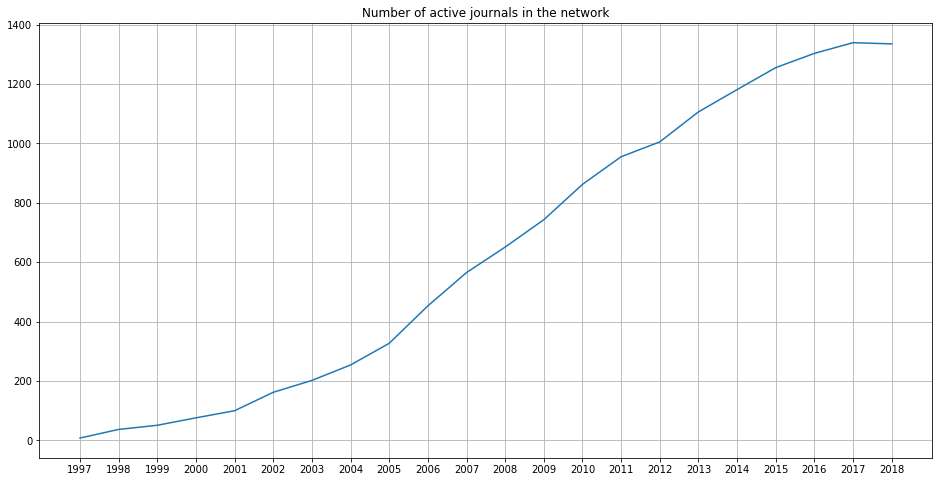

In [21]:
network_index["total"].plot(
    figsize=(16, 8),
    title="Number of active journals in the network",
    xticks=network_index.index,
    grid=True,
);

## Collection-specific analysis

In the data de-duplication section,
we had already normalized the rows to ensure every entry has a distinct ISSN.
If we hadn't, now that would need to be done
in order to properly count the entries of each collection.

Yearly, how many journals had been indexed for each collection?
Let's see the cumulative number of journals indexed until a certain year for every collection.

In [22]:
indexed_on = dataset.groupby(["inclusion year at SciELO", "collection"]) \
                    .size().unstack().fillna(0).sort_index(axis=1).sort_index()
indexed_on.cumsum()

collection,arg,bol,chl,col,cri,cub,ecu,esp,mex,per,prt,psi,rve,rvt,scl,spa,sss,sza,ury,ven
inclusion year at SciELO,,,,,,,,,,,,,,,,,,,,
1997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0
1998,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,2.0,0.0,0.0,0.0,0.0
1999,0.0,0.0,13.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,35.0,5.0,0.0,0.0,0.0,0.0
2000,0.0,0.0,20.0,0.0,0.0,4.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,54.0,5.0,0.0,0.0,0.0,0.0
2001,0.0,0.0,25.0,0.0,0.0,4.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,6.0,0.0,0.0,0.0,5.0
2002,0.0,0.0,35.0,3.0,10.0,9.0,0.0,9.0,1.0,0.0,0.0,0.0,1.0,0.0,96.0,8.0,0.0,0.0,0.0,9.0
2003,3.0,0.0,39.0,3.0,10.0,10.0,0.0,13.0,1.0,0.0,3.0,1.0,1.0,0.0,115.0,8.0,0.0,0.0,0.0,17.0
2004,4.0,0.0,47.0,6.0,10.0,15.0,0.0,21.0,1.0,7.0,4.0,4.0,1.0,0.0,130.0,9.0,0.0,0.0,0.0,23.0
2005,17.0,0.0,56.0,7.0,10.0,17.0,0.0,25.0,6.0,8.0,8.0,26.0,1.0,0.0,147.0,12.0,4.0,0.0,0.0,26.0


The number of indexed by year, instead of the cumulative values,
can be seen in a heat map:

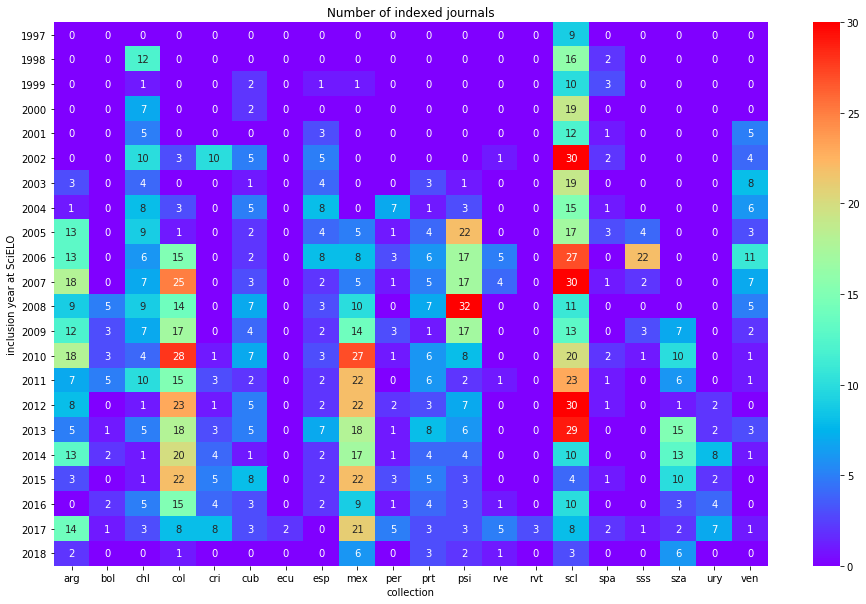

In [23]:
sns.heatmap(indexed_on,
    cmap="rainbow", fmt="g", annot=True,
    vmin=0, vmax=30,
    ax=plt.subplots(figsize=(16, 10))[1]
).set(title="Number of indexed journals");

And the same regarding the deindexed entries:

In [24]:
deindexed_on = dataset.groupby(["stopping year at SciELO", "collection"]) \
                      .size().drop(np.inf).unstack().fillna(0).sort_index(axis=1).sort_index()
deindexed_on.cumsum()

collection,arg,bol,chl,col,cri,cub,esp,mex,prt,psi,rve,scl,spa,sss,sza,ury,ven
stopping year at SciELO,,,,,,,,,,,,,,,,,
1997.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
2001.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0
2002.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0
2003.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0
2004.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0
2005.0,0.0,0.0,4.0,0.0,1.0,0.0,4.0,1.0,0.0,4.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0
2006.0,1.0,0.0,5.0,0.0,2.0,0.0,5.0,2.0,0.0,5.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0


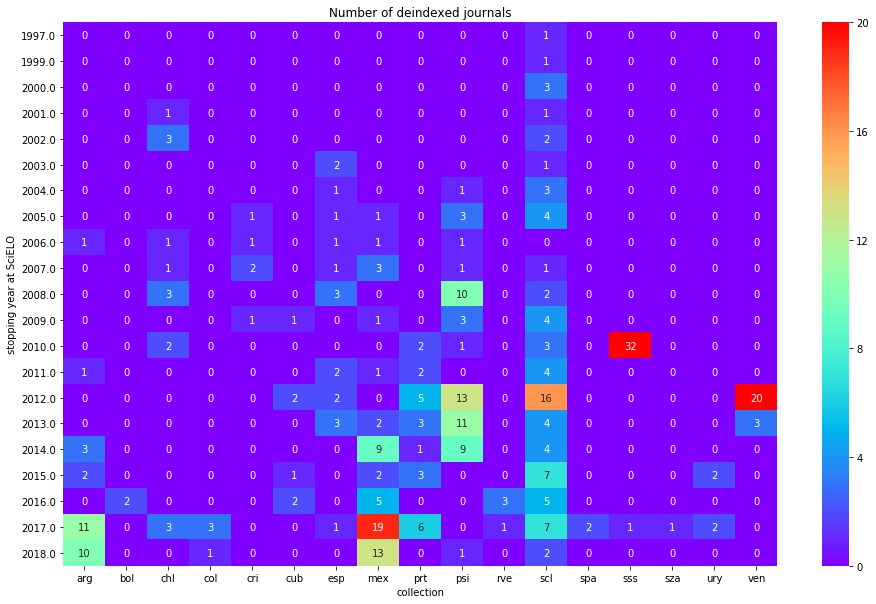

In [25]:
sns.heatmap(deindexed_on,
    cmap="rainbow", fmt="g", annot=True,
    vmin=0, vmax=20,
    ax=plt.subplots(figsize=(16, 10))[1]
).set(title="Number of deindexed journals");

We can join these in a single table
by stacking the collection as a secondary row index:

In [26]:
indexed_deindexed_df = pd.DataFrame([
    indexed_on.stack().rename("indexed"),
    deindexed_on.stack().rename("deindexed"),
]).T.fillna(0)
indexed_deindexed_df.iloc[::31]

,,indexed,deindexed
1997,arg,0.0,0.0
1998,psi,0.0,0.0
2000,chl,7.0,0.0
2001,rvt,0.0,0.0
2003,cri,0.0,0.0
2004,spa,1.0,0.0
2006,ecu,0.0,0.0
2007,sza,0.0,0.0
2009,mex,14.0,1.0
2010,ven,1.0,0.0


That makes it easier to plot both information at once for a single collection,
for example:

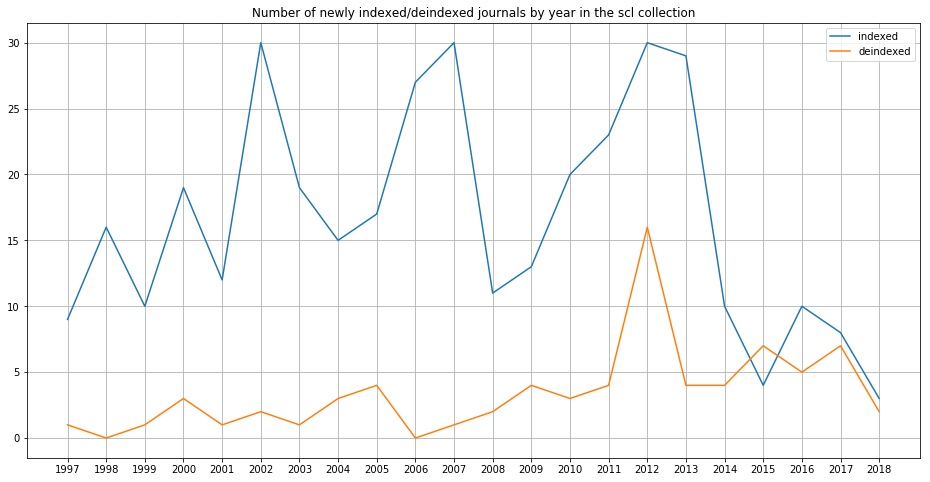

In [27]:
indexed_deindexed_df.reorder_levels([1, 0]).loc["scl"].plot(
    figsize=(16, 8),
    title="Number of newly indexed/deindexed journals by year in the scl collection",
    xticks=range(1997, 2019),
    grid=True,
);

We can get the active journals for all the collections
directly from the two dataframes
with the indexed and deindexed counts:

In [28]:
active_on = indexed_on.__sub__(deindexed_on, fill_value=0).cumsum()
active_on

collection,arg,bol,chl,col,cri,cub,ecu,esp,mex,per,prt,psi,rve,rvt,scl,spa,sss,sza,ury,ven
1997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0
1998,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,2.0,0.0,0.0,0.0,0.0
1999,0.0,0.0,13.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,33.0,5.0,0.0,0.0,0.0,0.0
2000,0.0,0.0,20.0,0.0,0.0,4.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,49.0,5.0,0.0,0.0,0.0,0.0
2001,0.0,0.0,24.0,0.0,0.0,4.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,60.0,6.0,0.0,0.0,0.0,5.0
2002,0.0,0.0,31.0,3.0,10.0,9.0,0.0,9.0,1.0,0.0,0.0,0.0,1.0,0.0,88.0,8.0,0.0,0.0,0.0,9.0
2003,3.0,0.0,35.0,3.0,10.0,10.0,0.0,11.0,1.0,0.0,3.0,1.0,1.0,0.0,106.0,8.0,0.0,0.0,0.0,17.0
2004,4.0,0.0,43.0,6.0,10.0,15.0,0.0,18.0,1.0,7.0,4.0,3.0,1.0,0.0,118.0,9.0,0.0,0.0,0.0,23.0
2005,17.0,0.0,52.0,7.0,9.0,17.0,0.0,21.0,5.0,8.0,8.0,22.0,1.0,0.0,131.0,12.0,4.0,0.0,0.0,26.0
2006,29.0,0.0,57.0,22.0,8.0,19.0,0.0,28.0,12.0,11.0,14.0,38.0,6.0,0.0,158.0,12.0,26.0,0.0,0.0,37.0


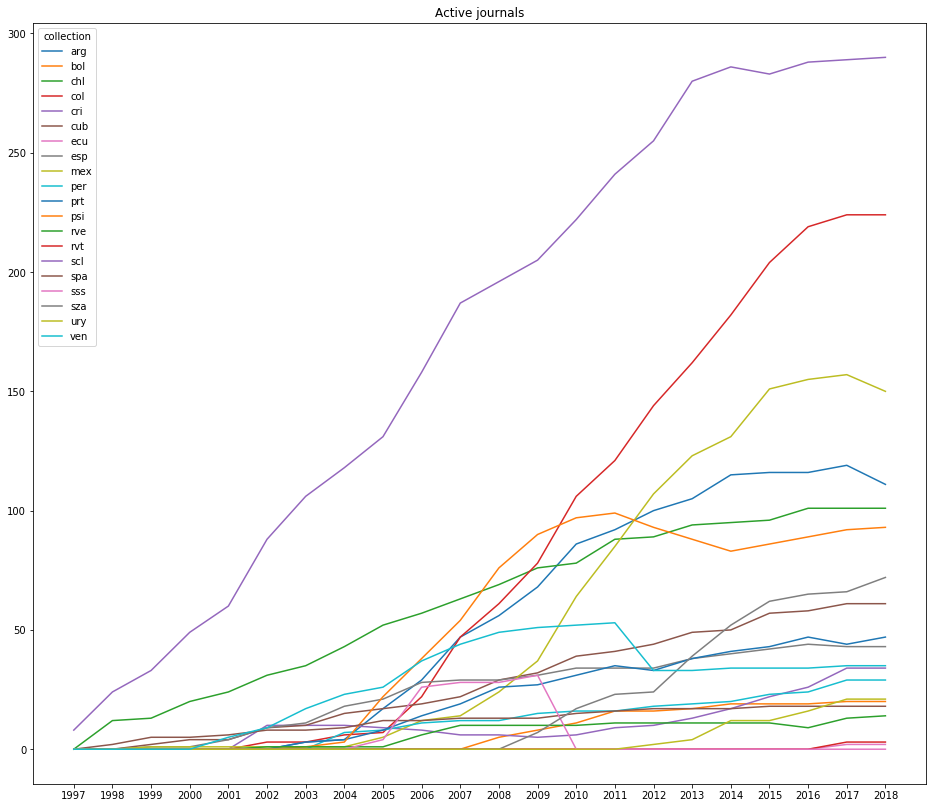

In [29]:
active_on.plot(figsize=(16, 14), xticks=active_on.index,
               title="Active journals");

The total number of active journals in 2018 for each collection is:

In [30]:
active_on.loc[2018].sort_values()

collection
sss      0.0
ecu      2.0
rvt      3.0
rve     14.0
spa     18.0
bol     20.0
ury     21.0
per     29.0
cri     34.0
ven     35.0
esp     43.0
prt     47.0
cub     61.0
sza     72.0
psi     93.0
chl    101.0
arg    111.0
mex    150.0
col    224.0
scl    290.0
Name: 2018, dtype: float64

Seeing just parts of the data:

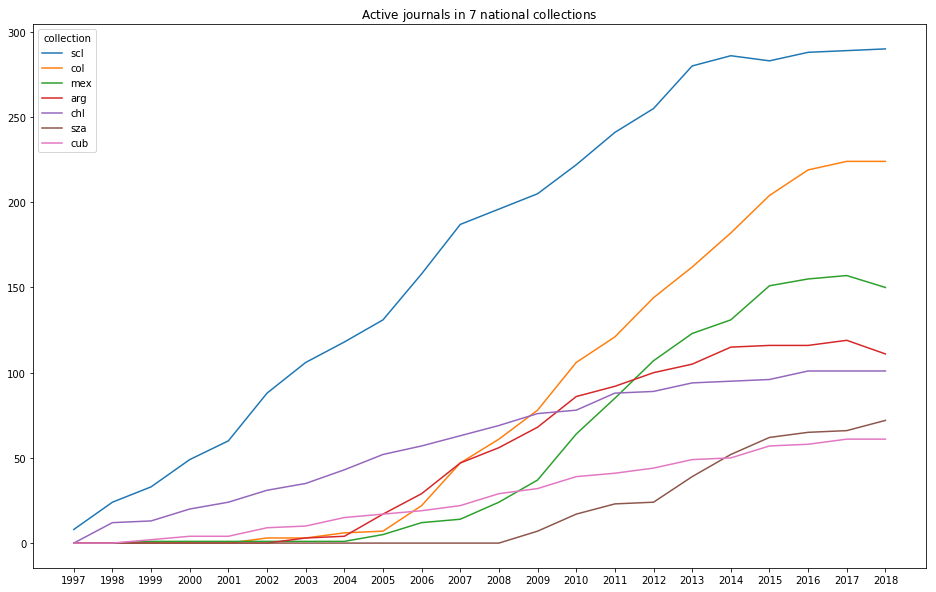

In [31]:
active_on[["scl", "col", "mex", "arg", "chl", "sza", "cub"]] \
         .plot.line(figsize=(16, 10), xticks=active_on.index,
                    title="Active journals in $7$ national collections");

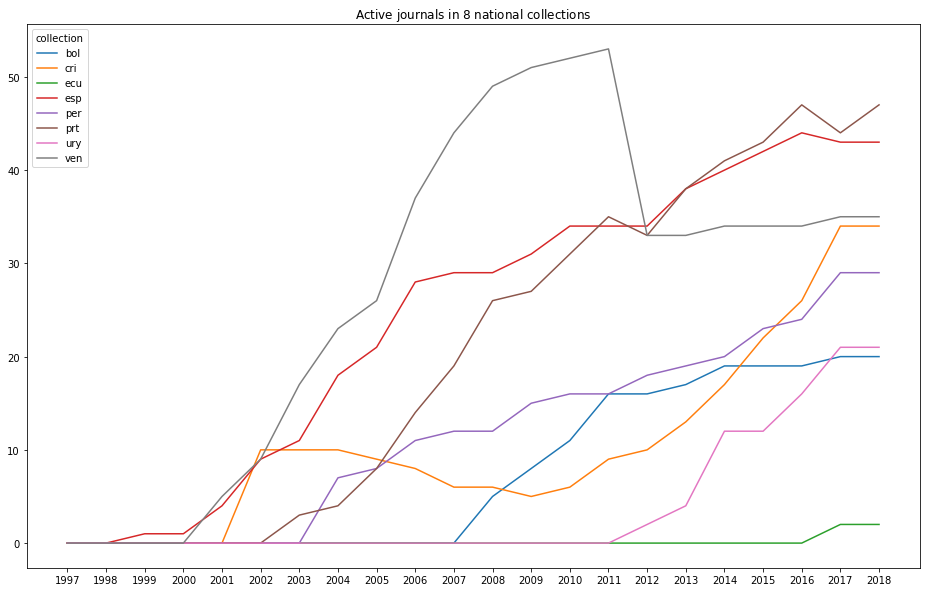

In [32]:
active_on.drop(columns=["scl", "col", "mex", "arg", "chl", "sza", "cub",
                        "psi", "rve", "rvt", "spa", "sss"]) \
         .plot.line(figsize=(16, 10), xticks=active_on.index,
                    title="Active journals in $8$ national collections");

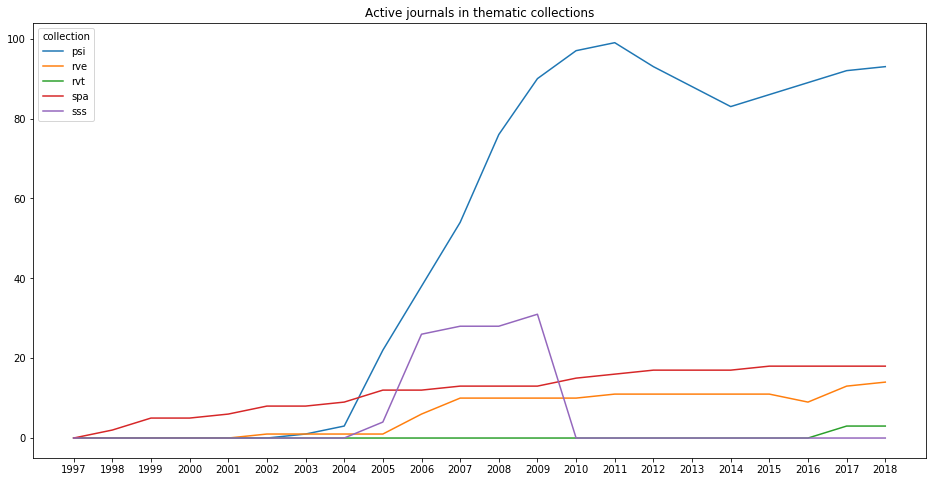

In [33]:
active_on[["psi", "rve", "rvt", "spa", "sss"]] \
         .plot.line(figsize=(16, 8), xticks=active_on.index,
                    title="Active journals in thematic collections");

Or, a subplots visualization of it all (without markers):

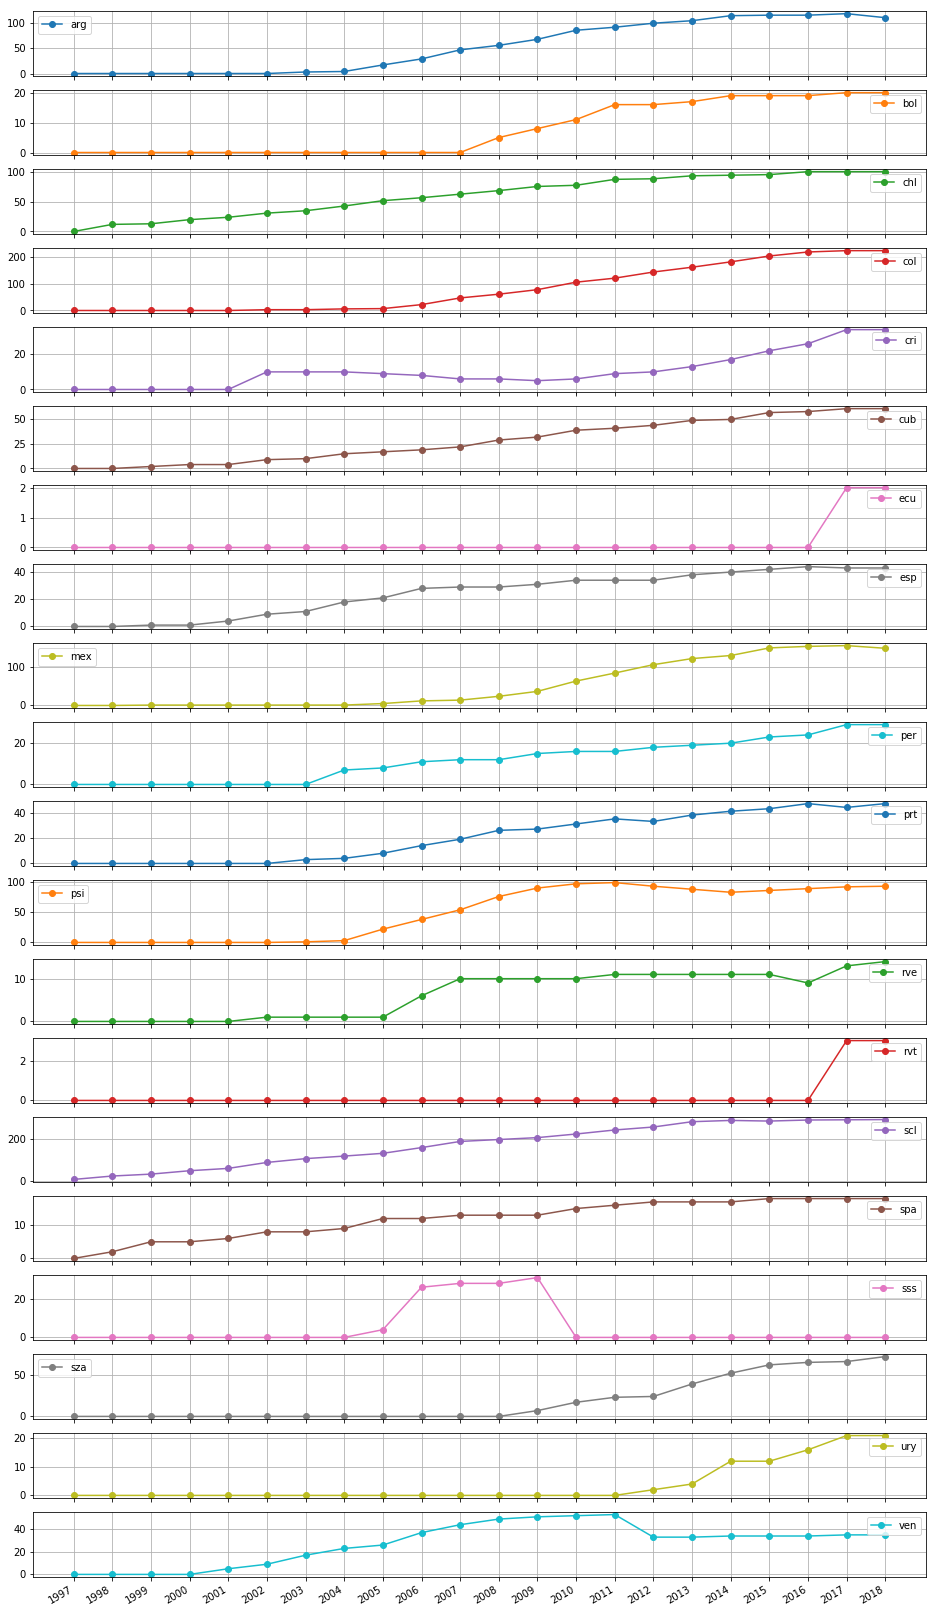

In [34]:
active_on.plot(
    subplots=True,
    figsize=(16, 32),
    xticks=active_on.index,
    grid=True,
    marker="o",
);

## Summing the collection-specific entries

Usually we shouldn't sum the count of the collection-specific entries,
because they have some intersection (the same ISSN)
and that would add some residual to our results.
To give some sense of how much residual is that,
let's calculate it!

In [35]:
collections_sum = active_on.T.sum()
collections_sum

1997       8.0
1998      38.0
1999      55.0
2000      80.0
2001     104.0
2002     169.0
2003     209.0
2004     262.0
2005     340.0
2006     477.0
2007     595.0
2008     689.0
2009     784.0
2010     884.0
2011     980.0
2012    1030.0
2013    1130.0
2014    1205.0
2015    1279.0
2016    1328.0
2017    1371.0
2018    1368.0
dtype: float64

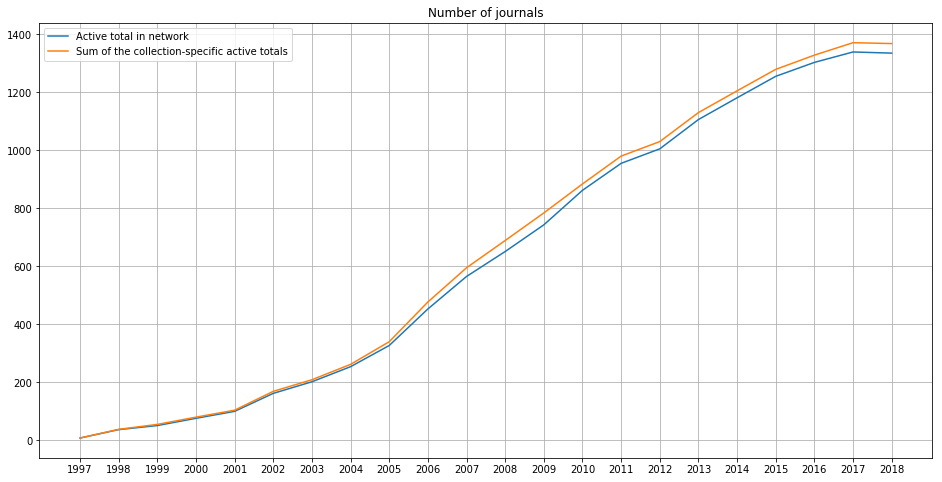

In [36]:
pd.DataFrame({
    "Active total in network": network_index["total"],
    "Sum of the collection-specific active totals": collections_sum,
}).plot(
    figsize=(16, 8),
    title="Number of journals",
    xticks=network_index.index,
    grid=True,
);

The shape is almost the same, but it's a $2.5\%$ error in $2018$.

In [37]:
(collections_sum[2018] - network_index["total"][2018]) / network_index["total"][2018]

0.024719101123595506